## NB1. ROF global monthly, annual, seasonal flows analysis <a id='top'></a>

Use 

1. reach-D19 gauge link ascii
2. D19 flow site geopackage
3. D19 discharge netCDF
4. monthly and yearly flow netCD (history file)

[1. Setupt](#setup)

[2. Loading data](#load_data)

- monthly history files (directory from CESM or postprocessed) from archive. 

- Reference data is monthly discharge estimates at 922 big river mouths from Dai et al. 2019 data (D19)

[3. Large 24 river analysis](#24_large_rivers)

- Plotting time seriese (annual, seasonal cycle) and scatter plots at Large 24 selected rivers with D19 referece data

[4. Large 50 rivers analysis](#50_large_rivers)

- Annual flow summary table at large 50 selected rivers. 

[5. 922 rivers analysis](#922_rivers)

- summary statistics (%bias, rmse, correlation) at all 922 river sites - map and boxplots.

[6. basin area vs annual flow](#flow_diagnoisis)

Moved this to another notebook

In [1]:
%matplotlib inline

import os, sys
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from dask_jobqueue import PBSCluster
from dask.distributed import Client

import scripts.colors as colors
from scripts.utility import load_yaml
from scripts.utility import no_time_variable

print("\nThe Python version: %s.%s.%s" % sys.version_info[:3])
print(xr.__name__, xr.__version__)
print(pd.__name__, pd.__version__)
print(gpd.__name__, gpd.__version__)


The Python version: 3.11.4
xarray 2024.7.0
pandas 2.2.2
geopandas 1.0.1


-------------------------
## 1. Setup <a id='setup'></a>

[go back to top](#top)

In [2]:
# analysis_name = analysis name
# cases = CESM case names and their runoff grid

analysis_name = "lake_test"

cases = {
    # "f09_f09_rHDMA": "rHDMA",
    # "f09_f09_rHDMAlk": "rHDMAlk",
    "f09_f09_rHDMAlk_h06": "rHDMAlk_h06",
    #'f09_f09_rHDMAlk_irrig_limited':'rHDMAlk_irrig_limited',
    #'f09_f09_mg17':'f09_f09',
    "f09_f09_mg17_mosart": "f09_f09_mosart",
    #'standard_NH_flood':'f09_f09_mosart',
}

error_metric = "rmse"

parallel = False

figureSave = False

-------------------------
load config files and some parameters 

In [3]:
setup = load_yaml("./setup/setup.yaml")

main_dir = setup["archive_dir"]  # CESM archive directory
domain_dir = setup["ancillary_dir"]  # ancillary directory including such as ROF domain
geospatial_dir = setup["ancillary_dir"]  # including shapefiles etc
ref_flow_dir = setup["ref_flow_dir"]  # including observed or reference flow data
syr = setup["syr"]  # analysis start year
eyr = setup["eyr"]  # analysis end year
case_meta = setup["case_meta"]  # Case metadata
reach_gpkg = setup["reach_gpkg"]  # reach geopackage meta

time_period = slice(f"{syr}-01-01", f"{eyr}-12-31")  # analysis time period
nyrs = eyr - syr + 1  # number of years
nmons = nyrs * 12  # number of months

-----
### dasks (optional)

In [4]:
if parallel:
    cluster = PBSCluster(queue="casper", memory="10GB", processes=1)
    cluster.scale(jobs=10)
    client = Client(cluster)
    client

## 2. Loading data <a id='load_data'></a>

[go back to top](#top)

### 2.1. Mmonthly/annual flow netCDFs
- month_data (xr dataset)
- year_data (xr dataset)
- seas_data (xr dataset)

In [5]:
%%time

reachID = {}
month_data = {}
year_data = {}
seas_data = {}
for case, grid_name in cases.items():
    in_dire = os.path.join(main_dir, case, "rof/hist")
    model = case_meta[grid_name]["model"]
    domain = case_meta[grid_name]["domain_nc"]
    # monthly
    month_data[case] = (
        xr.open_mfdataset(
            f"{in_dire}/{case}.{model}.*.month.nc",
            data_vars="minimal",
            chunks={"time": 12},
        )
        .sel(time=time_period)
        .load()
    )
    # annual
    year_data[case] = (
        xr.open_mfdataset(
            f"{in_dire}/{case}.{model}.*.annual.nc",
            data_vars="minimal",
            chunks={"time": 1},
        )
        .sel(time=time_period)
        .load()
    )
    # seasonal (compute here instead of reading for conisistent analysis period)
    seas_data[case] = month_data[case].groupby("time.month").mean("time")
    vars_no_time = no_time_variable(month_data[case])
    seas_data[case][vars_no_time] = seas_data[case][vars_no_time].isel(
        month=0, drop=True
    )

    if domain == "None":
        reachID[case] = month_data[case]["reachID"].values
    else:
        reachID[case] = xr.open_dataset(f"{domain_dir}/{domain}")["reachID"].values
    print(f"Finished loading {case}")

Finished loading f09_f09_rHDMAlk_h06
Finished loading f09_f09_mg17_mosart
CPU times: user 10.6 s, sys: 2.57 s, total: 13.1 s
Wall time: 1min 8s


### 2.2 Large river ID and name ascii
- big_river_50: dictionary {_site_id_:_river name_}
- big_river_24: dictionary {_site_id_:_river name_}

In [6]:
df = pd.read_csv("./setup/large_river_50.txt", index_col="river_name")
big_river_50 = {key: values["site_id"] for key, values in df.iterrows()}
big_river_24 = {
    key: values["site_id"] for ix, (key, values) in enumerate(df.iterrows()) if ix < 24
}  # The first 24 is used for plots

### 2.3. reach-D19 gauge link csv
- gauge_reach_lnk (dataframe)

In [7]:
gauge_reach_lnk = {}
for case, grid_name in cases.items():
    gauge_reach_lnk[case] = pd.read_csv(
        "%s/D09/D09_925.%s.asc" % (ref_flow_dir, case_meta[grid_name]["network"])
    )

### 2.4 D19 flow site shapefile
- gauge_shp (dataframe)

In [8]:
%%time

gauge_shp = gpd.read_file(
    os.path.join(ref_flow_dir, "D09", "geospatial", "D09_925.gpkg")
)
gauge_shp = gauge_shp[gauge_shp["id"] != 9999999]

CPU times: user 14.1 ms, sys: 7.21 ms, total: 21.3 ms
Wall time: 92.5 ms


### 2.5 D19 discharge data
- ds_q_obs_mon (xr datasets)
- ds_q_obs_yr (xr datasets)
- dr_q_obs_seasonal (xr datasets)

In [9]:
%%time

# read monthly data
ds_q = xr.open_dataset(
    "%s/D09/coastal-stns-Vol-monthly.updated-May2019.mod.nc" % (ref_flow_dir),
    decode_times=False,
)
ds_q["time"] = xr.cftime_range(
    start="1900-01-01", end="2018-12-01", freq="MS", calendar="standard"
)

# monthly
ds_q_obs_mon = ds_q["FLOW"].sel(time=time_period)
# compute annual flow from monthly
ds_q_obs_yr = ds_q_obs_mon.resample(time="YE").mean(dim="time")
# compute annual cycle at monthly scale
dr_q_obs_seasonal = (
    ds_q_obs_mon.sel(time=time_period).groupby("time.month").mean("time")
)

CPU times: user 62.4 ms, sys: 7.55 ms, total: 69.9 ms
Wall time: 172 ms


### 2.6 Get indices in obs and sim data for gauge name (processing)
- gauge_plot (dictionary)

In [10]:
## function to get reach indice in history file corresponding to river sites
def find_seg_id(site_id, reachID_array, df_gauge_reach):
    gauge_ix = [
        i for i, gid in enumerate(ds_q.id.values) if gid == site_id
    ]  # go through gauge obs data and get index of matching to river (gauge) name
    gauge_id = ds_q.id.values[gauge_ix][0]  ## guage ID
    seg_id = df_gauge_reach.loc[df_gauge_reach["gauge_id"] == gauge_id][
        "route_id"
    ].values  # matching reach ID in river network
    seg_ix = np.argwhere(reachID_array == seg_id)  # matching reach ix in river network
    if len(seg_ix) == 0:
        seg_ix = -999
    else:
        seg_ix = seg_ix[0]
    return gauge_ix, seg_ix, seg_id

In [11]:
gauge_plot = {}
for gname, site_id in big_river_50.items():
    gauge_plot[gname] = {}
    for case, _ in cases.items():
        gauge_ix, seg_index, seg_id = find_seg_id(
            site_id, reachID[case], gauge_reach_lnk[case]
        )
        gauge_plot[gname][case] = [gauge_ix, seg_index, seg_id]

------
## 3. Analysis for 24 large rivers <a id='24_large_rivers'></a>

[go back to top](#top)

### 3.1 Annual flow series

CPU times: user 462 ms, sys: 0 ns, total: 462 ms
Wall time: 1.79 s


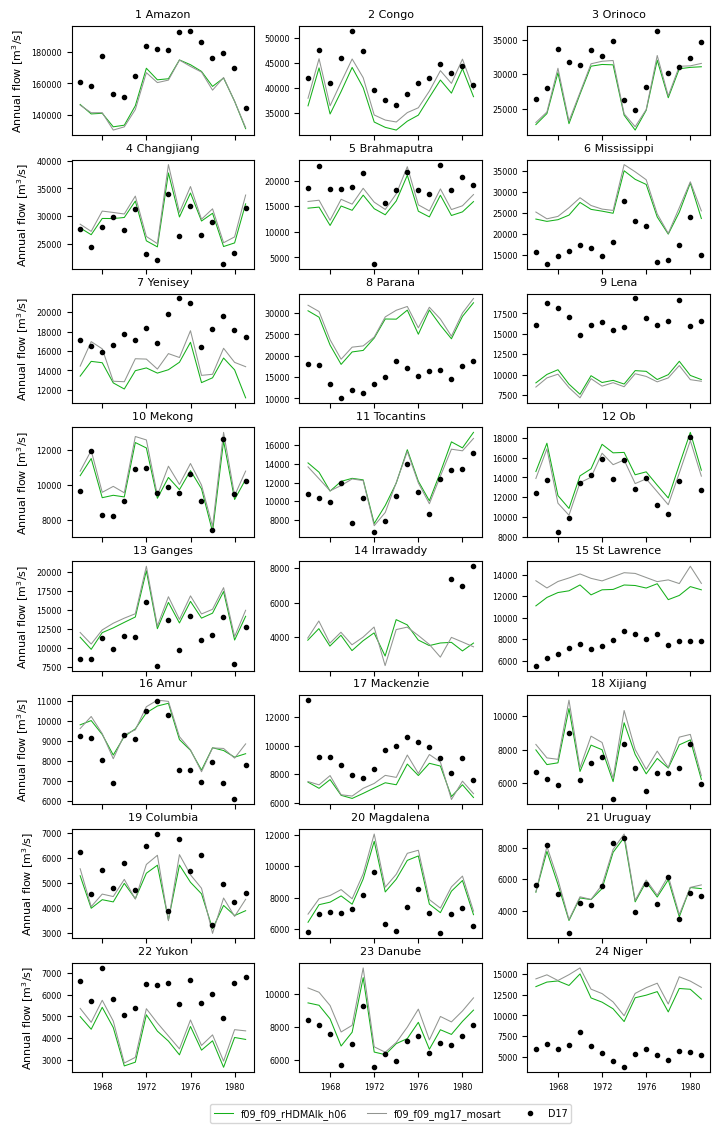

In [12]:
%%time

fig, axes = plt.subplots(8, 3, figsize=(7.25, 11.5))
plt.subplots_adjust(
    top=0.975, bottom=0.065, right=0.98, left=0.10, hspace=0.225, wspace=0.250
)  # create some space below the plots by increasing the bottom-value

for ix, river_name in enumerate(big_river_24.keys()):
    row = ix // 3
    col = ix % 3
    for case in cases.keys():
        grid_name = cases[case]
        net_idx = gauge_plot[river_name][case][1]
        gaug_idx = gauge_plot[river_name][case][0]

        q_name = case_meta[grid_name]["flow_name"]
        color = case_meta[grid_name]["color"]

        if len(net_idx) == 1:
            year_data[case][q_name][:, net_idx].plot(
                ax=axes[row, col], linestyle="-", c=color, lw=0.75, label=case
            )
        elif len(net_idx) == 2:  # means 2d grid
            year_data[case][q_name][:, net_idx[0], net_idx[1]].plot(
                ax=axes[row, col], linestyle="-", c=color, lw=0.75, label=case
            )

    ds_q_obs_yr.loc[:, gaug_idx].plot(
        ax=axes[row, col],
        linestyle="None",
        marker="o",
        markersize=3,
        c="k",
        label="D17",
    )

    axes[row, col].set_title("%d %s" % (ix + 1, river_name), fontsize=8)

    axes[row, col].set_xlabel("")
    if row < 7:
        axes[row, col].set_xticklabels("")
    if col == 0:
        axes[row, col].set_ylabel("Annual flow [m$^3$/s]", fontsize=8)
    else:
        axes[row, col].set_ylabel("")
    axes[row, col].tick_params("both", labelsize="xx-small")

# Legend- make space below the plot-raise bottom. there will be an label below the second last (bottom middle) ax, thanks to the bbox_to_anchor=(x, y) with a negative y-value.
axes.flatten()[-2].legend(
    loc="upper center",
    bbox_to_anchor=(0.125, -0.35, 0.75, 0.1),
    ncol=5,
    fontsize="x-small",
)

if figureSave:
    plt.savefig(f"./NB1_Fig1_big_river_annual_{analysis_name}.png", dpi=200)

### 3.2. Annual cycle (at monthly step)

CPU times: user 265 ms, sys: 0 ns, total: 265 ms
Wall time: 310 ms


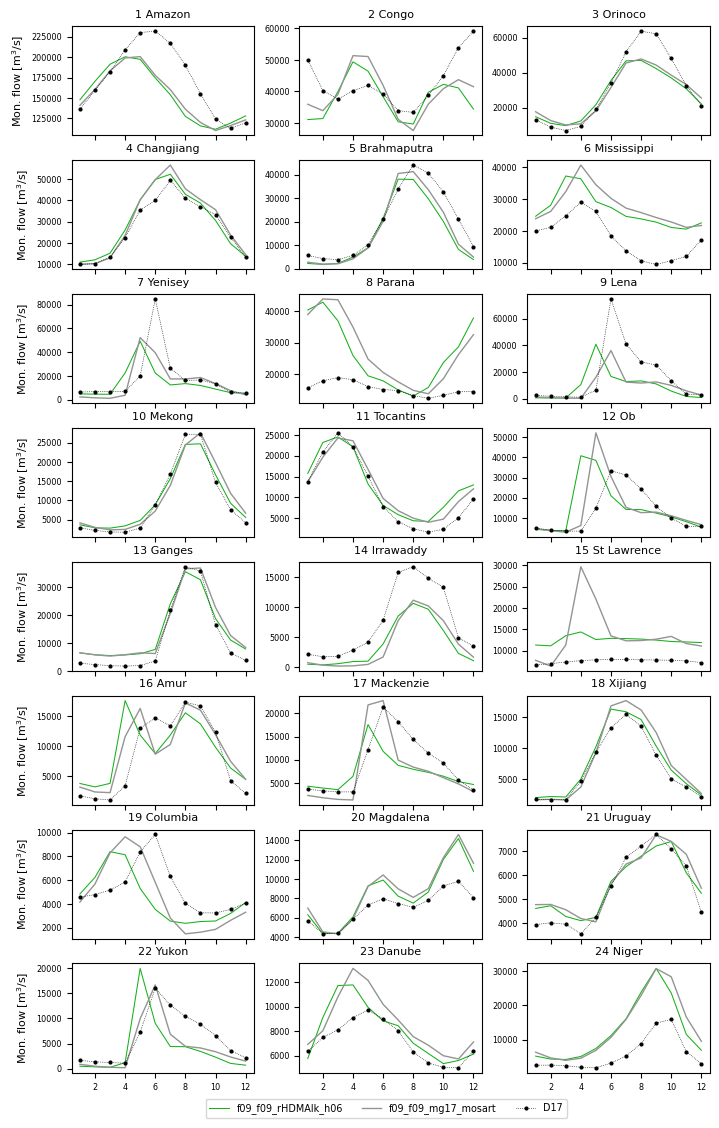

In [13]:
%%time

fig, axes = plt.subplots(8, 3, figsize=(7.25, 11.5))
plt.subplots_adjust(
    top=0.975, bottom=0.065, right=0.98, left=0.10, hspace=0.225, wspace=0.250
)  # create some space below the plots by increasing the bottom-value

for ix, river_name in enumerate(big_river_24.keys()):
    row = ix // 3
    col = ix % 3
    for case in cases.keys():
        grid_name = cases[case]

        net_idx = gauge_plot[river_name][case][1]
        gaug_idx = gauge_plot[river_name][case][0]

        q_name = case_meta[grid_name]["flow_name"]
        color = case_meta[grid_name]["color"]

        if len(net_idx) == 1:  # means vector
            seas_data[case][q_name][:, net_idx].plot(
                ax=axes[row, col], linestyle="-", c=color, lw=0.75, label=case
            )
        elif len(net_idx) == 2:  # means 2d grid
            seas_data[case][q_name][:, net_idx[0], net_idx[1]].plot(
                ax=axes[row, col], linestyle="-", c=color, lw=1.0, label=case
            )

    dr_q_obs_seasonal.loc[:, gaug_idx].plot(
        ax=axes[row, col],
        linestyle=":",
        lw=0.5,
        marker="o",
        markersize=2,
        c="k",
        label="D17",
    )

    axes[row, col].set_title("%d %s" % (ix + 1, river_name), fontsize=8)
    axes[row, col].set_xlabel("")
    if row < 7:
        axes[row, col].set_xticklabels("")
    if col == 0:
        axes[row, col].set_ylabel("Mon. flow [m$^3$/s]", fontsize=8)
    else:
        axes[row, col].set_ylabel("")
    axes[row, col].tick_params("both", labelsize="xx-small")

# Legend- make space below the plot-raise bottom. there will be an label below the second last (bottom middle) ax, thanks to the bbox_to_anchor=(x, y) with a negative y-value.
axes.flatten()[-2].legend(
    loc="upper center",
    bbox_to_anchor=(0.10, -0.30, 0.75, 0.1),
    ncol=5,
    fontsize="x-small",
)

if figureSave:
    plt.savefig(f"./NB1_Fig2_big_river_season_{analysis_name}.png", dpi=200)

### 3.3. scatter plots of monthly flow

CPU times: user 270 ms, sys: 0 ns, total: 270 ms
Wall time: 309 ms


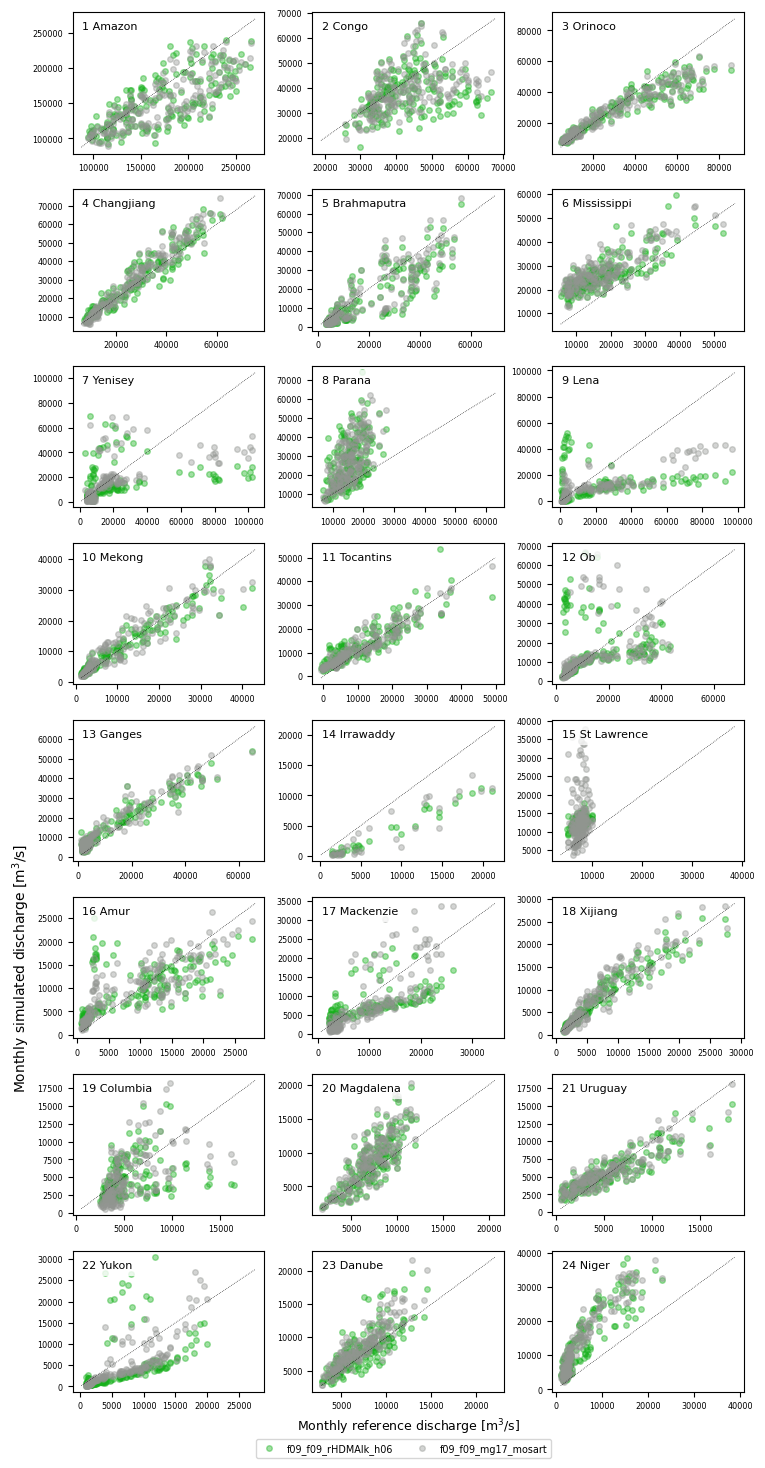

In [14]:
%%time
# Monthly flow scatter plot

fig, axes = plt.subplots(8, 3, figsize=(7.50, 15.00))
plt.subplots_adjust(
    top=0.995, bottom=0.075, right=0.995, left=0.1, wspace=0.25, hspace=0.25
)

for ix, river_name in enumerate(big_river_24.keys()):
    row = ix // 3
    col = ix % 3
    axes[row, col].yaxis.set_major_formatter(FormatStrFormatter("%.0f"))

    for jx, case in enumerate(cases.keys()):
        grid_name = cases[case]

        net_idx = gauge_plot[river_name][case][1]
        gaug_idx = gauge_plot[river_name][case][0]

        q_name = case_meta[grid_name]["flow_name"]
        color = case_meta[grid_name]["color"]

        if len(net_idx) == 1:  # means vector
            ds_sim = month_data[case][q_name][:, net_idx].sel(time=time_period)
        elif len(net_idx) == 2:  # means 2d grid
            ds_sim = (
                month_data[case][q_name][:, net_idx[0], net_idx[1]]
                .sel(time=time_period)
                .squeeze()
            )

        ds_obs = ds_q_obs_mon.sel(time=time_period).loc[:, gaug_idx]

        axes[row, col].plot(
            ds_obs, ds_sim, "o", c=color, label=case, markersize=4.0, alpha=0.4
        )
        if jx == 0:
            max_val = np.max(ds_obs)
            min_val = np.min(ds_obs)
        else:
            max_val = np.max([np.max(ds_sim), max_val])
            min_val = np.min([np.min(ds_sim), min_val])

    axes[row, col].plot(
        [min_val * 0.98, max_val * 1.02],
        [min_val * 0.98, max_val * 1.02],
        ":k",
        linewidth=0.5,
    )

    axes[row, col].annotate(
        "%d %s" % (ix + 1, river_name),
        xy=(0.05, 0.875),
        xycoords="axes fraction",
        fontsize=8,
        bbox=dict(facecolor="white", edgecolor="None", alpha=0.8),
    )
    if row == 7 and col == 1:
        axes[row, col].set_xlabel("Monthly reference discharge [m$^3$/s]", fontsize=9)
    else:
        axes[row, col].set_xlabel("")

    if col == 0 and row == 5:
        axes[row, col].set_ylabel("Monthly simulated discharge [m$^3$/s]", fontsize=10)
    else:
        axes[row, col].set_ylabel("")
    axes[row, col].tick_params("both", labelsize="xx-small")

axes.flatten()[-2].legend(
    loc="upper center",
    bbox_to_anchor=(0.10, -0.40, 0.75, 0.1),
    ncol=5,
    fontsize="x-small",
)

if figureSave:
    plt.savefig(f"./NB1_Fig3_big_river_month_scatter_{analysis_name}.png", dpi=200)

### 3.4. scatter plots of annual flow

CPU times: user 387 ms, sys: 5.85 ms, total: 393 ms
Wall time: 410 ms


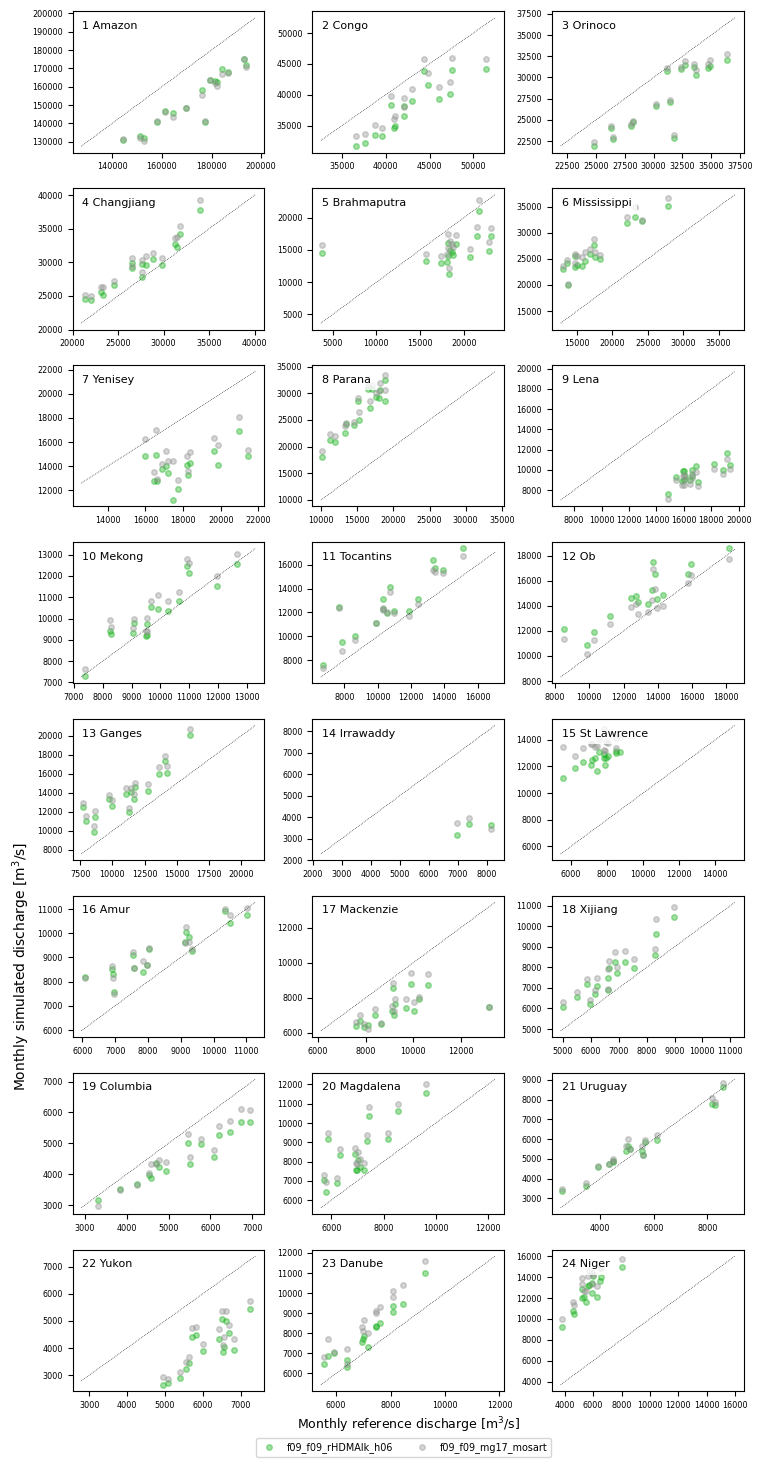

In [15]:
%%time
# annual flow scatter plot

fig, axes = plt.subplots(8, 3, figsize=(7.50, 15.00))
plt.subplots_adjust(
    top=0.995, bottom=0.075, right=0.995, left=0.1, wspace=0.25, hspace=0.25
)

for ix, river_name in enumerate(big_river_24.keys()):
    row = ix // 3
    col = ix % 3
    axes[row, col].yaxis.set_major_formatter(FormatStrFormatter("%.0f"))

    for jx, case in enumerate(cases.keys()):
        grid_name = cases[case]

        net_idx = gauge_plot[river_name][case][1]
        gaug_idx = gauge_plot[river_name][case][0]

        q_name = case_meta[grid_name]["flow_name"]
        color = case_meta[grid_name]["color"]

        if len(net_idx) == 1:  # means vector
            ds_sim = year_data[case][q_name][:, net_idx].sel(time=time_period)
        elif len(net_idx) == 2:  # means 2d grid
            ds_sim = year_data[case][q_name][:, net_idx[0], net_idx[1]].sel(
                time=time_period
            )

        ds_obs = ds_q_obs_yr.sel(time=time_period).loc[:, gaug_idx]

        axes[row, col].plot(
            ds_obs, ds_sim, "o", c=color, label=case, markersize=4.0, alpha=0.4
        )
        if jx == 0:
            max_val = np.max(ds_obs)
            min_val = np.min(ds_obs)
        else:
            max_val = np.max([np.max(ds_sim), max_val])
            min_val = np.min([np.min(ds_sim), min_val])

    axes[row, col].plot(
        [min_val * 0.98, max_val * 1.02],
        [min_val * 0.98, max_val * 1.02],
        ":k",
        linewidth=0.5,
    )

    axes[row, col].annotate(
        "%d %s" % (ix + 1, river_name),
        xy=(0.05, 0.875),
        xycoords="axes fraction",
        fontsize=8,
        bbox=dict(facecolor="white", edgecolor="None", alpha=0.8),
    )
    if row == 7 and col == 1:
        axes[row, col].set_xlabel("Monthly reference discharge [m$^3$/s]", fontsize=9)
    else:
        axes[row, col].set_xlabel("")

    if col == 0 and row == 5:
        axes[row, col].set_ylabel("Monthly simulated discharge [m$^3$/s]", fontsize=10)
    else:
        axes[row, col].set_ylabel("")
    axes[row, col].tick_params("both", labelsize="xx-small")

axes.flatten()[-2].legend(
    loc="upper center",
    bbox_to_anchor=(0.10, -0.40, 0.75, 0.1),
    ncol=5,
    fontsize="x-small",
)

if figureSave:
    plt.savefig(f"./NB1_Fig4_big_river_annual_scatter_{analysis_name}.png", dpi=200)

## 4. Anaysis for Large 50 rivers <a id='50_large_rivers'></a>

[go back to top](#top)

### 4.1 Summary tables

In [16]:
%%time

with open(f"large50rivers_{analysis_name}.txt", "w") as f:
    # some meta
    f.write("# obs: Dai et al.(2019)\n")
    f.write("# vol: km^3/yr\n")
    f.write("# area: km^2\n")

    # headers
    f.write("No,          river_name,")
    f.write("{0: >15}_vol,".format("obs"))
    for jx, case in enumerate(cases.keys()):
        grid_name = cases[case]
        f.write("{0: >15}_vol,".format(grid_name))
    f.write("{0: >15}_area".format("obs"))
    for jx, case in enumerate(cases.keys()):
        grid_name = cases[case]
        f.write(",")
        f.write("{0: >15}_area".format(grid_name))
    f.write("\n")

    # data for each river
    for ix, river_name in enumerate(big_river_50.keys()):

        f.write("%02d," % (ix + 1))
        f.write("{0: >20}".format(river_name))

        for jx, case in enumerate(cases.keys()):
            grid_name = cases[case]
            f.write(",")
            net_idx = gauge_plot[river_name][case][1]
            gaug_idx = gauge_plot[river_name][case][0]

            q_name = case_meta[grid_name]["flow_name"]

            if len(net_idx) == 1:  # means vector
                qsim = (
                    np.nanmean(
                        year_data[case][q_name][:, net_idx].sel(time=time_period).values
                    )
                    * 60
                    * 60
                    * 24
                    * 365
                    / 10**9
                )
            elif len(net_idx) == 2:  # means 2d grid
                qsim = (
                    np.nanmean(
                        year_data[case][q_name][:, net_idx[0], net_idx[1]]
                        .sel(time=time_period)
                        .values
                    )
                    * 60
                    * 60
                    * 24
                    * 365
                    / 10**9
                )

            if jx == 0:
                qobs = (
                    np.nanmean(
                        ds_q_obs_yr.sel(time=time_period).loc[:, gaug_idx].values
                    )
                    * 60
                    * 60
                    * 24
                    * 365
                    / 10**9
                )

                f.write("{:19.1f},".format(qobs))
            f.write("{:19.1f}".format(qsim))

        for jx, case in enumerate(cases.keys()):
            grid_name = cases[case]
            f.write(",")
            gaug_idx = gauge_plot[river_name][case][0]

            # just get gauge_id from qs_q for now
            gauge_id = ds_q["id"].loc[gaug_idx].values[0]
            network_area = gauge_reach_lnk[case][
                gauge_reach_lnk[case]["gauge_id"] == gauge_id
            ]["route_area"].values[0]

            if jx == 0:
                area = ds_q["area_stn"].loc[gaug_idx].values[0]
                f.write("{:20.0f},".format(area))

            f.write("{:20.0f}".format(network_area))

        f.write("\n")

CPU times: user 177 ms, sys: 0 ns, total: 177 ms
Wall time: 214 ms


### 4.2. scatter plot of annual mean flow

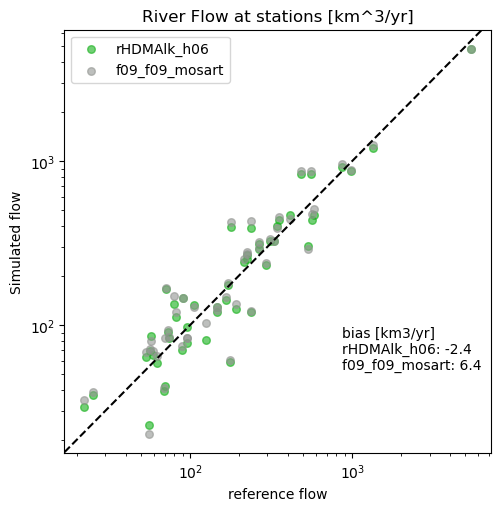

In [18]:
df_yr_vol = pd.read_csv(
    f"./large50rivers_{analysis_name}.txt",
    skiprows=3,
    index_col=["No"],
    skipinitialspace=True,
)

fig, axes = plt.subplots(1, figsize=(5.50, 5.50))
regressor = LinearRegression()
bias_text = ""

for jx, case in enumerate(cases.keys()):
    grid_name = cases[case]

    # compute linear regression
    df_reg = df_yr_vol[["obs_vol", f"{grid_name}_vol"]].dropna()
    regressor.fit(df_reg[["obs_vol"]], df_reg[f"{grid_name}_vol"])
    y_pred = regressor.predict(df_reg[["obs_vol"]])

    # compute bias over 50 sites
    diff = (df_yr_vol[f"{grid_name}_vol"] - df_yr_vol["obs_vol"]).mean(
        axis=0, skipna=True
    )

    # color assigned to grid name
    color = case_meta[grid_name]["color"]

    df_yr_vol.plot(
        ax=axes,
        kind="scatter",
        x="obs_vol",
        y=f"{grid_name}_vol",
        s=30,
        color=color,
        alpha=0.6,
        label=grid_name,
    )
    # plt.plot(df_reg['obs_vol'], y_pred, color=color)
    bias_text = bias_text + f"\n{grid_name}: {diff:.1f} "

plt.text(0.65, 0.30, "bias [km3/yr]", transform=axes.transAxes, verticalalignment="top")
plt.text(0.65, 0.30, f"{bias_text} ", transform=axes.transAxes, verticalalignment="top")

plt.axline((0, 0), slope=1, linestyle="--", color="black")
axes.set_xscale("log")
axes.set_yscale("log")
axes.set_xlabel("reference flow")
axes.set_ylabel("Simulated flow")
axes.set_title("River Flow at stations [km^3/yr]")

if figureSave:
    plt.savefig(
        f"./NB1_Fig5_50big_river_annual_flow_scatter_{analysis_name}.png", dpi=200
    )

------
## 3. Anaysis for all 922 sites <a id='922_rivers'></a>

[go back to top](#top)

### 3.1 Compute metris at all the sites (no plots nor tables)

In [19]:
%%time

# Merge gauge_reach lnk (dataframe) into gauge shapefile
gauge_shp1 = {}
for case, df in gauge_reach_lnk.items():
    # df = df.loc[(df['flag'] == 0)]
    df1 = df.drop(columns=["riv_name"])
    gauge_shp1[case] = pd.merge(
        gauge_shp, df1, how="inner", left_on="id", right_on="gauge_id"
    )

# compute %bias, correlation, and RMSE at each site based on monthly
mon_pbias = {}
mon_corr = {}
mon_rmse = {}

for case, grid_name in cases.items():

    bias = np.full(len(gauge_shp1[case]), np.nan, dtype=float)
    corr = np.full(len(gauge_shp1[case]), np.nan, dtype=float)
    rmse = np.full(len(gauge_shp1[case]), np.nan, dtype=float)

    for ix, row in gauge_shp1[case].iterrows():
        q_obs = np.full(
            nmons, np.nan, dtype=float
        )  # dummy q_sim that will be replaced by actual data if exist
        q_sim = np.full(
            nmons, np.nan, dtype=float
        )  # dummy q_sim that will be replaced by actual data if exist

        route_id = row["route_id"]
        gauge_id = row["gauge_id"]

        q_name = case_meta[grid_name]["flow_name"]

        gauge_ix = np.argwhere(ds_q.id.values == gauge_id)
        if len(gauge_ix) == 1:
            gauge_ix = gauge_ix[0]
            q_obs = ds_q_obs_mon[:, gauge_ix].squeeze().values

        route_ix = np.argwhere(reachID[case] == route_id)
        if (
            len(route_ix) == 1
        ):  # meaning there is flow site in network and simulation exist at this site
            route_ix = route_ix[0]
            if len(route_ix) == 1:  # means vector
                q_sim = month_data[case][q_name][:, route_ix].squeeze().values
            elif len(route_ix) == 2:  # means 2d grid
                q_sim = (
                    month_data[case][q_name][:, route_ix[0], route_ix[1]]
                    .squeeze()
                    .values
                )

            # compute %bias, correlation, RMSE
            bias[ix] = np.nanmean(q_sim - q_obs) / np.nanmean(q_obs) * 100.0
            corr[ix] = np.corrcoef(q_sim, q_obs)[0, 1]
            rmse[ix] = np.sqrt(np.mean((q_sim - q_obs) ** 2))

    mon_pbias[case] = bias
    mon_corr[case] = corr
    mon_rmse[case] = rmse

    gauge_shp1[case][f"bias_{grid_name}"] = bias
    gauge_shp1[case][f"corr_{grid_name}"] = corr
    gauge_shp1[case][f"rmse_{grid_name}"] = rmse

<timed exec>:54: RuntimeWarning: Mean of empty slice
/glade/work/mizukami/conda-envs/cupid-analysis/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/glade/work/mizukami/conda-envs/cupid-analysis/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
<timed exec>:54: RuntimeWarning: Mean of empty slice


CPU times: user 3.32 s, sys: 358 μs, total: 3.32 s
Wall time: 4.32 s


/glade/work/mizukami/conda-envs/cupid-analysis/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/glade/work/mizukami/conda-envs/cupid-analysis/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


### 4.2. Spatial metric map 

In [20]:
rivers_50m = cfeature.NaturalEarthFeature("physical", "rivers_lake_centerlines", "50m")
land = cfeature.LAND

CPU times: user 156 ms, sys: 0 ns, total: 156 ms
Wall time: 159 ms


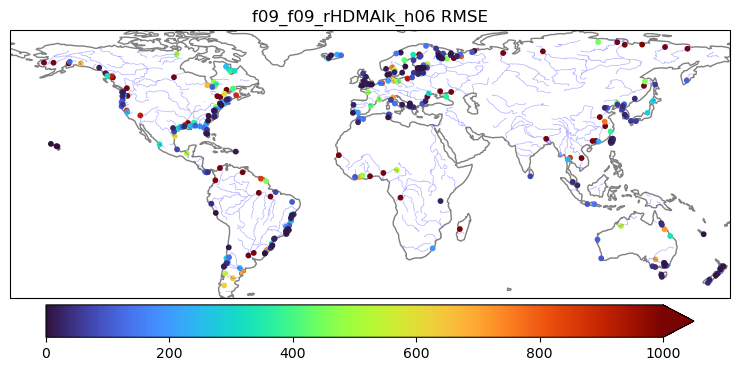

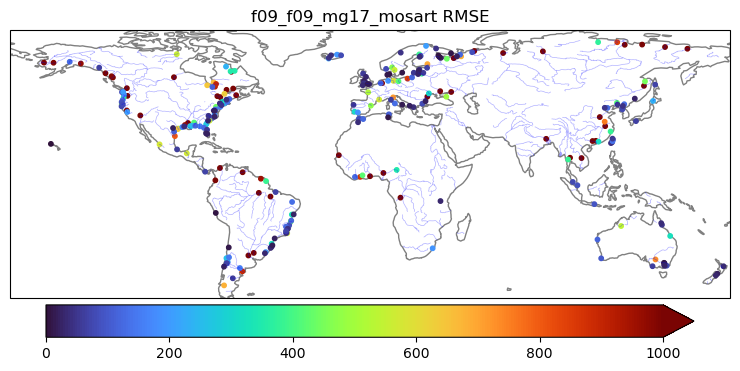

In [22]:
%%time

# some local plot setups
cbar_kwrgs = {
    "bias": {"shrink": 0.9, "pad": 0.02, "orientation": "horizontal", "extend": "both"},
    "corr": {"shrink": 0.9, "pad": 0.02, "orientation": "horizontal", "extend": "min"},
    "rmse": {"shrink": 0.9, "pad": 0.02, "orientation": "horizontal", "extend": "max"},
}

meta = {
    "bias": {"name": "%bias", "vmin": -100, "vmax": 100, "cm": colors.cmap11},
    "corr": {"name": "correlation", "vmin": 0.2, "vmax": 1, "cm": colors.cmap12},
    "rmse": {"name": "RMSE", "vmin": 0, "vmax": 1000, "cm": mpl.cm.turbo},
}

for case in cases.keys():
    fig, ax = plt.subplots(
        1, figsize=(7.5, 4.0), subplot_kw={"projection": ccrs.PlateCarree()}
    )

    ax.add_feature(rivers_50m, facecolor="None", edgecolor="b", lw=0.5, alpha=0.3)
    ax.add_feature(land, facecolor="white", edgecolor="grey")

    gauge_shp1[case].plot(
        ax=ax,
        column=f"{error_metric}_{cases[case]}",
        markersize=10,
        cmap=meta[error_metric]["cm"],
        vmin=meta[error_metric]["vmin"],
        vmax=meta[error_metric]["vmax"],
    )

    ax.set_title("%s %s" % (case, meta[error_metric]["name"]))

    points = ax.collections[-1]
    plt.colorbar(points, ax=ax, **cbar_kwrgs[error_metric])

    plt.tight_layout()

    if figureSave:
        plt.savefig(f"./NB1_Fig6_{error_metric}_{case}_map.png", dpi=200)

### 4.3 Error metrics boxplots 
The box extends from the Q1 to Q3 quartile values of the data, with a line at the median (Q2). 
The whiskers extend from the edges of box to show the range of the data. 
By default, they extend no more than 1.5 * IQR (IQR = Q3 - Q1) from the edges of the box, ending at the farthest data point within that interval. 
Outliers are plotted as separate dots.


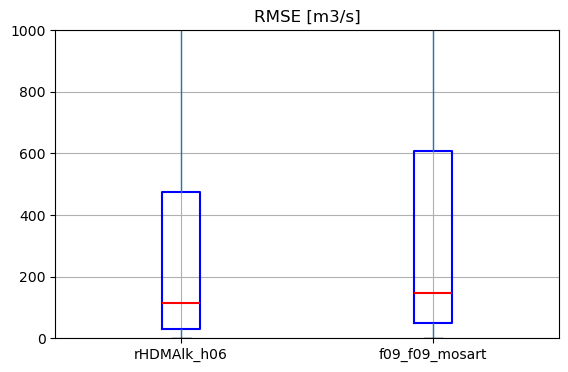

In [24]:
column_stat = []
gauge_shp_all_case = gauge_shp.copy(deep=True)
for case, grid_name in cases.items():
    gauge_shp_all_case = gauge_shp_all_case.merge(
        gauge_shp1[case][["id", f"{error_metric}_{grid_name}"]],
        left_on="id",
        right_on="id",
    )
    column_stat.append(f"{error_metric}_{grid_name}")

boxprops = {"linestyle": "-", "linewidth": 1.5, "color": "blue"}
medianprops = {"linestyle": "-", "linewidth": 1.5, "color": "red"}

fig, ax = plt.subplots(1, figsize=(6.5, 4))
gauge_shp_all_case.boxplot(
    ax=ax, column=column_stat, boxprops=boxprops, medianprops=medianprops, sym="."
)

xticklabels = [label[len(error_metric) + 1 :] for label in column_stat]
ax.set_xticklabels(xticklabels)

if error_metric == "rmse":
    ax.set_ylim([0, 1000])
    ax.set_title("RMSE [m3/s]")
elif error_metric == "bias":
    ax.set_ylim([-150, 250])
    ax.set_title("%bias [%]")
elif error_metric == "corr":
    ax.set_ylim([-0.2, 1])
    ax.set_title("correlation")

if figureSave:
    plt.savefig(f"./NB1_Fig7_{error_metric}_boxplot.png", dpi=150)